In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import qmc
import torch.nn as nn
import time
from pyDOE import lhs
from scipy.special import jv, hankel1
from functools import partial  # Higher-order functions and operations on callable objects
from pinns import derivative, MLP, init_weights
import warnings
from scat_circ import *
# Suppress warnings to keep the output clean
warnings.filterwarnings("ignore")
from scat_circ import sound_hard_circle_calc
from scat_circ import mask_displacement
from scat_circ import plot_displacement_amplitude
import time

ModuleNotFoundError: No module named 'pinns'

In [ ]:
r_i = pi/4 # Inner radius
r_e = pi # Outer radius
r_a = 11.0 # Radius of the outermost layer
k = 2.0  # Wave number
n_grid = 501 # Number of grid points in x and y 

In [ ]:
# Create a grid of points in the domain
Y_exact, X_exact = np.mgrid[-r_e:r_e:n_grid*1j, -r_e:r_e:n_grid*1j]

# Calculate the radial distance from the origin for each point in the grid
R_exact = np.sqrt(X_exact**2 + Y_exact**2)

# Calculate the displacement for a sound-hard circular obstacle
# n_terms: number of terms in the series expansion
u_sc, u = sound_hard_circle_calc(k, r_i, X_exact, Y_exact, n_terms=None)

# Mask the displacement
u_sc, u = mask_displacement(R_exact, r_i, r_e, u_sc, u)

In [43]:
def f(model, x_f, y_f, k):
    """
    Calculate the Helmholtz equation components for the given model and input domain.

    Parameters:
    model (torch.nn.Module): The neural network model.
    x_f (torch.Tensor): Tensor of x-coordinates of the input domain.
    y_f (torch.Tensor): Tensor of y-coordinates of the input domain.
    k (float): Wave number.

    Returns:
    torch.Tensor: Real part of the Helmholtz equation components.
    torch.Tensor: Imaginary part of the Helmholtz equation components.
    """
    # Concatenate x_f and y_f to form the input domain
    domain = torch.stack((x_f, y_f), dim=1)
    
    # Pass the domain through the model to get the output
    u = model(domain)
    
    # Extract real and imaginary parts
    u_real = u[:, 0]
    u_imag = u[:, 1]
    
    # Calculate second-order derivatives
    u_real_xx = derivative(u_real, x_f, order=2)
    u_real_yy = derivative(u_real, y_f, order=2)
    u_imag_xx = derivative(u_imag, x_f, order=2)
    u_imag_yy = derivative(u_imag, y_f, order=2)
    
    # Calculate the Helmholtz equation components
    f_u_real = u_real_xx + u_real_yy + k**2 * u_real
    f_u_imag = u_imag_xx + u_imag_yy + k**2 * u_imag
    
    return f_u_real, f_u_imag

def mse_f(model, x_f, y_f, k):
    """
    Calculate the mean squared error (MSE) for the Helmholtz equation components.

    Parameters:
    model (torch.nn.Module): The neural network model.
    x_f (torch.Tensor): Tensor of x-coordinates of the input domain.
    y_f (torch.Tensor): Tensor of y-coordinates of the input domain.
    k (float): Wave number.

    Returns:
    torch.Tensor: Mean squared error for the Helmholtz equation components.
    """
    # Calculate f(x, y) from the neural network
    f_u_real, f_u_imag = f(model, x_f, y_f, k)
    
    # Calculate the mean squared error for the real and imaginary parts
    error_f_real = torch.mean(f_u_real**2)
    error_f_imag = torch.mean(f_u_imag**2)
    
    # Sum the errors to obtain the total MSE
    mse = error_f_real + error_f_imag
      
    return mse

In [44]:
def mse_b(model, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top, k):
    """
    Calculate the mean squared error (MSE) for boundary conditions of a scattering problem.
    Parameters:
    model (torch.nn.Module): The neural network model used to approximate the solution.
    x_inner (torch.Tensor): x-coordinates of the inner boundary points.
    y_inner (torch.Tensor): y-coordinates of the inner boundary points.
    x_left (torch.Tensor): x-coordinates of the left boundary points.
    y_left (torch.Tensor): y-coordinates of the left boundary points.
    x_right (torch.Tensor): x-coordinates of the right boundary points.
    y_right (torch.Tensor): y-coordinates of the right boundary points.
    x_bottom (torch.Tensor): x-coordinates of the bottom boundary points.
    y_bottom (torch.Tensor): y-coordinates of the bottom boundary points.
    x_top (torch.Tensor): x-coordinates of the top boundary points.
    y_top (torch.Tensor): y-coordinates of the top boundary points.
    k (float): Wave number.
    Returns:
    float: The total mean squared error for all boundary conditions.
    """
    def calculate_mse_boundary(x, y, model, k, boundary_type):
        domain = torch.stack((x, y), axis=1)
        u = model(domain)
        u_real = u[:, 0]
        u_imag = u[:, 1]
        
        if boundary_type == 'inner':
            theta = torch.atan2(y, x)
            du_real_dx = derivative(u_real, x, order=1)
            du_real_dy = derivative(u_real, y, order=1)
            du_imag_dx = derivative(u_imag, x, order=1)
            du_imag_dy = derivative(u_imag, y, order=1)
            du_real_dn = -(torch.cos(theta) * du_real_dx + torch.sin(theta) * du_real_dy)
            du_imag_dn = -(torch.cos(theta) * du_imag_dx + torch.sin(theta) * du_imag_dy)
            ikx = 1j * k * x
            exp_ikx = 1j * k * torch.exp(ikx) * (torch.cos(theta))
            exp_ikx_real = torch.real(exp_ikx)
            exp_ikx_imag = torch.imag(exp_ikx)
            error_real = du_real_dn - exp_ikx_real
            error_imag = du_imag_dn - exp_ikx_imag
        
        elif boundary_type in ['left', 'right']:
            du_real_dx = derivative(u_real, x, order=1)
            du_imag_dx = derivative(u_imag, x, order=1)
            du_real_dn = (-1 if boundary_type == 'left' else 1) * du_real_dx
            du_imag_dn = (-1 if boundary_type == 'left' else 1) * du_imag_dx
            error_real = du_real_dn - (-k * u_imag)
            error_imag = du_imag_dn - (k * u_real)
        
        elif boundary_type in ['bottom', 'top']:
            du_real_dy = derivative(u_real, y, order=1)
            du_imag_dy = derivative(u_imag, y, order=1)
            du_real_dn = (-1 if boundary_type == 'bottom' else 1) * du_real_dy
            du_imag_dn = (-1 if boundary_type == 'bottom' else 1) * du_imag_dy
            error_real = du_real_dn - (-k * u_imag)
            error_imag = du_imag_dn - (k * u_real)
        
        mse = ((error_real)**2 + (error_imag)**2).mean()
        return mse

    mse_inner = calculate_mse_boundary(x_inner, y_inner, model, k, 'inner')
    mse_left = calculate_mse_boundary(x_left, y_left, model, k, 'left')
    mse_right = calculate_mse_boundary(x_right, y_right, model, k, 'right')
    mse_bottom = calculate_mse_boundary(x_bottom, y_bottom, model, k, 'bottom')
    mse_top = calculate_mse_boundary(x_top, y_top, model, k, 'top')

    mse = mse_inner + mse_left + mse_right + mse_bottom + mse_top
    return mse


In [45]:
def train_adam(model, x_f, y_f, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top, k, num_iter=5_000):
 
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    global iter
     
    for i in range(1, num_iter + 1):
        optimizer.zero_grad()
        loss_f = mse_f(model, x_f, y_f, k)
        loss_b = mse_b(model, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top, k)
        loss = loss_f + loss_b
        loss.backward(retain_graph=True)
        optimizer.step()
        iter += 1
        if iter % 1000 == 0:
            print(f"Adam - Iter: {iter} - Loss: {loss.item()}")

In [46]:
def closure(model, optimizer, x_f, y_f, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top, k):
    
    # Reset gradients
    optimizer.zero_grad()
    
    # Calculate the loss
    loss_f = mse_f(model, x_f, y_f, k)
    loss_b = mse_b(model, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top, k)
    loss = loss_b + loss_f
    
    # Backpropagate the loss
    loss.backward(retain_graph=True)
    
    # Update iteration counter and print loss every 100 iterations
    global iter
    iter += 1
    if iter % 1000 == 0:
        print(f"Iteration {iter}, Loss: {loss.item()}")
            
    return loss

In [47]:
# Function for L-BFGS training
def train_lbfgs(model, x_f, y_f, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top, k, num_iter=5_000):

    optimizer = torch.optim.LBFGS(model.parameters(),
                                    lr=1,
                                    max_iter=num_iter,
                                    max_eval=num_iter,
                                    tolerance_grad=1e-7,
                                    history_size=100,
                                    tolerance_change=1.0 * np.finfo(float).eps,
                                    line_search_fn="strong_wolfe")
 
    closure_fn = partial(closure, model, optimizer, x_f, y_f, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top, k)
    optimizer.step(closure_fn)

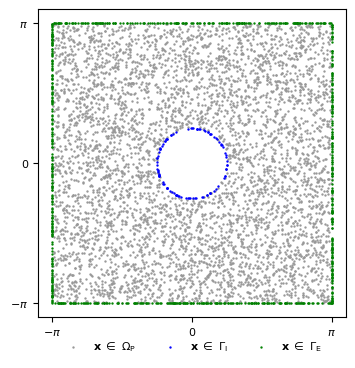

In [70]:
# Define the device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Parameters
n_Omega_P = 5_000        # Number of points inside the annular region
n_Gamma_I = 100          # Number of points on the inner boundary (r = r_i)
n_Gamma_E = 200          # Number of points on the outer boundary (r = r_e)
r_i = np.pi / 4          # Inner radius
r_e = np.pi              # Outer radius
k = 3.0                  # Wave number
iter = 0                 # Iteration counter
side_length = 2 * r_e    # Side length of the square

def generate_points(n_Omega_P, side_length, r_i, n_Gamma_I, n_boundary_e):
    """
    Generate points inside the domain and on the boundaries.

    Parameters:
    n_Omega_P (int): Number of points inside the annular region.
    side_length (float): Side length of the square.
    r_i (float): Inner radius.
    n_Gamma_I (int): Number of points on the inner boundary.
    n_boundary_e (int): Number of points on each boundary.
    device (torch.device): Device to store the tensors.

    Returns:
    tuple: Tensors of x and y coordinates for points inside the domain, 
           on the inner boundary, and on the left, right, bottom, and top boundaries.
    """

    # Set the device
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    
    # Generate random samples for points inside the square but outside the circle
    points = []
    while len(points) < n_Omega_P:
        x_samples = side_length * (np.random.rand(n_Omega_P) - 0.5)
        y_samples = side_length * (np.random.rand(n_Omega_P) - 0.5)
        mask = (x_samples**2 + y_samples**2) >= r_i**2
        points.extend(zip(x_samples[mask], y_samples[mask]))

    # Trim the list to the desired number of points
    points = points[:n_Omega_P]
    x_samples, y_samples = zip(*points)

    # Convert to numpy arrays
    x_f = np.array(x_samples)
    y_f = np.array(y_samples)

    # Generate random points on the inner boundary (r = r_i)
    theta_inner = 2 * np.pi * np.random.rand(n_Gamma_I)  # Uniform angular distribution
    x_inner = r_i * np.cos(theta_inner)
    y_inner = r_i * np.sin(theta_inner)

    # Generate random points on the left, right, bottom, and top boundaries of the square

    # Left boundary (excluding corners)
    y_left = side_length * (np.random.rand(n_boundary_e) - 0.5)
    x_left = -side_length / 2 * np.ones_like(y_left)

    # Right boundary (excluding corners)
    y_right = side_length * (np.random.rand(n_boundary_e) - 0.5)
    x_right = side_length / 2 * np.ones_like(y_right)

    # Bottom boundary (excluding corners)
    x_bottom = side_length * (np.random.rand(n_boundary_e) - 0.5)
    y_bottom = -side_length / 2 * np.ones_like(x_bottom)

    # Top boundary (excluding corners)
    x_top = side_length * (np.random.rand(n_boundary_e) - 0.5)
    y_top = side_length / 2 * np.ones_like(x_top)

    # Convert to torch tensors
    x_f = torch.from_numpy(x_f).float().to(device).requires_grad_(True)
    y_f = torch.from_numpy(y_f).float().to(device).requires_grad_(True)
    x_inner = torch.from_numpy(x_inner).float().to(device).requires_grad_(True)
    y_inner = torch.from_numpy(y_inner).float().to(device).requires_grad_(True)
    x_left = torch.from_numpy(x_left).float().to(device).requires_grad_(True)
    y_left = torch.from_numpy(y_left).float().to(device).requires_grad_(True)
    x_right = torch.from_numpy(x_right).float().to(device).requires_grad_(True)
    y_right = torch.from_numpy(y_right).float().to(device).requires_grad_(True)
    x_bottom = torch.from_numpy(x_bottom).float().to(device).requires_grad_(True)
    y_bottom = torch.from_numpy(y_bottom).float().to(device).requires_grad_(True)
    x_top = torch.from_numpy(x_top).float().to(device).requires_grad_(True)
    y_top = torch.from_numpy(y_top).float().to(device).requires_grad_(True)

    return x_f, y_f, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top

# Generate points
x_f, y_f, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top = generate_points(n_Omega_P, side_length, r_i, n_Gamma_I, n_Gamma_E)

def plot_points(x_f, y_f, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top):
    """
    Plot the points in the domain and on the boundaries.

    Parameters:
    x_f (torch.Tensor): x-coordinates of points inside the domain.
    y_f (torch.Tensor): y-coordinates of points inside the domain.
    x_inner (torch.Tensor): x-coordinates of points on the inner boundary.
    y_inner (torch.Tensor): y-coordinates of points on the inner boundary.
    x_left (torch.Tensor): x-coordinates of points on the left boundary.
    y_left (torch.Tensor): y-coordinates of points on the left boundary.
    x_right (torch.Tensor): x-coordinates of points on the right boundary.
    y_right (torch.Tensor): y-coordinates of points on the right boundary.
    x_bottom (torch.Tensor): x-coordinates of points on the bottom boundary.
    y_bottom (torch.Tensor): y-coordinates of points on the bottom boundary.
    x_top (torch.Tensor): x-coordinates of points on the top boundary.
    y_top (torch.Tensor): y-coordinates of points on the top boundary.
    """
    plt.figure(figsize=(4, 4))
    plt.scatter(x_f.cpu().detach().numpy(), y_f.cpu().detach().numpy(), c='#989898ff', s=2, marker='.', label=r"$\bf{x}$ $\in$ $\Omega_{\rm P}$")
    plt.scatter(x_inner.cpu().detach().numpy(), y_inner.cpu().detach().numpy(), c='#0000ffff', s=2, marker='.', label=r"$\bf{x}$ $\in$ $\Gamma_{\rm I}$")
    plt.scatter(x_left.cpu().detach().numpy(), y_left.cpu().detach().numpy(), c='#008000ff', s=2, marker='.', label=r"$\bf{x}$ $\in$ $\Gamma_{\rm E}$")
    plt.scatter(x_right.cpu().detach().numpy(), y_right.cpu().detach().numpy(), c='#008000ff', s=2, marker='.')
    plt.scatter(x_bottom.cpu().detach().numpy(), y_bottom.cpu().detach().numpy(), c='#008000ff', s=2, marker='.')
    plt.scatter(x_top.cpu().detach().numpy(), y_top.cpu().detach().numpy(), c='#008000ff', s=2, marker='.')
    plt.gca().set_aspect('equal', adjustable='box')

    # Set the ticks to include -pi and pi
    plt.xticks([-np.pi, 0, np.pi], [r'$-\pi$', '0', r'$\pi$'])
    plt.yticks([-np.pi, 0, np.pi], [r'$-\pi$', '0', r'$\pi$'])

    # Adjust the legend position and remove the box
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.04), frameon=False, ncol=3)

    # Show the plot
    plt.show()

# Call the function
plot_points(x_f, y_f, x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top)

In [ ]:
# Initialize the model with specified parameters and apply weights
model = MLP(input_size=2, output_size=2, hidden_layers=3, hidden_units=350, activation_function=nn.Tanh()).to(device)
# Initialize the weights

# Initialize the weights
model.apply(init_weights)

In [50]:
# Training with Adam optimizer
start_time_adam = time.time()
train_adam(model,x_f,y_f,x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top, k, num_iter = 5_000)
end_time_adam = time.time()
adam_training_time = end_time_adam - start_time_adam
print(f"Adam training time: {adam_training_time:.6e} seconds")

# Training with L-BFGS optimizer
start_time_lbfgs = time.time()
train_lbfgs(model,x_f,y_f,x_inner, y_inner, x_left, y_left, x_right, y_right, x_bottom, y_bottom, x_top, y_top, k, num_iter = 5_000)
end_time_lbfgs = time.time()
lbfgs_training_time = end_time_lbfgs - start_time_lbfgs
print(f"LBFGS training time: {lbfgs_training_time:.6e} seconds")

total_training_time = adam_training_time + lbfgs_training_time
print(f"Total training time: {total_training_time:.6e} seconds")

Adam - Iter: 1000 - Loss: 4.2547607421875
Adam - Iter: 2000 - Loss: 3.968477249145508
Adam - Iter: 3000 - Loss: 2.2245335578918457
Adam - Iter: 4000 - Loss: 0.6916243433952332
Adam - Iter: 5000 - Loss: 0.3402256369590759
Adam training time: 3.935052e+02 seconds
Iteration 6000, Loss: 0.012166241183876991
Iteration 7000, Loss: 0.0018224867526441813
Iteration 8000, Loss: 0.000787946511991322
Iteration 9000, Loss: 0.00043014760012738407
Iteration 10000, Loss: 0.0002628390211611986
LBFGS training time: 4.649557e+02 seconds
Total training time: 8.584608e+02 seconds


In [51]:
torch.save(model.state_dict(), f'Scattering.pt')

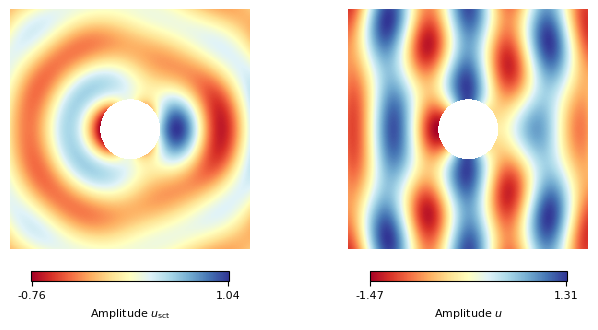

In [71]:
# Initialize and load the pre-trained model
model = MLP(input_size=2, output_size=2, hidden_layers=3, hidden_units=350, activation_function=nn.Tanh()).to(device) 
model_path = 'Scattering.pt'
model.load_state_dict(torch.load(model_path))
model.eval()


def predict_u(model, r_e, r_i, k, dom_samples=500):
    """
    Calculate the real part of the scattered field for a given model.

    Parameters:
    model (torch.nn.Module): The neural network model.
    r_e (float): Outer radius.
    r_i (float): Inner radius.
    k (float): Wave number.
    dom_samples (int): Number of samples in the domain.

    Returns:
    numpy.ma.core.MaskedArray: The masked scattered field.
    numpy.ma.core.MaskedArray: The total field.
    """
    # Set the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # x and y coordinates
    x = np.linspace(-r_e, r_e, dom_samples)
    y = np.linspace(-r_e, r_e, dom_samples)

    # Meshgrid of the domain
    X, Y = np.meshgrid(x, y)

    R_exact = np.sqrt(X**2 + Y**2)

    # Convert X and Y data to PyTorch tensors and reshape
    X_ten = torch.tensor(X).float().reshape(-1, 1).to(device)
    Y_ten = torch.tensor(Y).float().reshape(-1, 1).to(device)

    # Concatenate X and Y tensors into a single tensor
    domain_ten = torch.cat([X_ten, Y_ten], dim=1)
    u_sc_pred = model(domain_ten)
    u_sc_pred = u_sc_pred[:, 0].detach().cpu().numpy().reshape(X.shape)

    u_sc_pred = np.ma.masked_where(R_exact < r_i, u_sc_pred)

    us_inc = np.exp(1j * k * X)
    u_pred = np.real(us_inc + u_sc_pred)
    return u_sc_pred, u_pred

# Número de muestras en x y y
dom_samples = 501

x = np.linspace(-np.pi, np.pi, dom_samples)
y = np.linspace(-np.pi, np.pi, dom_samples)

# Malla del dominio
X, Y = np.meshgrid(x, y)

u_sc_pred, u_pred = predict_u(model, r_e, r_i, k, dom_samples)
 

# Plot the displacement amplitude
plot_displacement_amplitude(X, Y, u_sc_pred, u_pred)